# Clasificación

## Práctica

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

El dataset contiene datos relacionados con las campañas de marketing dirigidas (llamadas telefónicas) de una entidad bancaria portuguesa. El objetivo de la clasificación es predecir si el cliente suscribirá (1/0) un depósito a plazo (variable y).

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv')

El conjunto de datos proporciona la información de los clientes del banco. Incluye 41.188 registros y 21 campos.

In [3]:
data = data.dropna()
print(data.shape)
print(data.columns)

(41188, 21)
Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')


In [4]:
data.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1


**Variables de entrada**

*   edad (numérica)
*   trabajo : tipo de trabajo (categórico: "administrativo", "obrero", "empresario", "empleado doméstico", "directivo", "jubilado", "autónomo", "servicios", "estudiante", "técnico", "desempleado", "desconocido")
* marital : estado civil (categórico: "divorciado", "casado", "soltero", "desconocido")
* educación (categórica: "básico.4y", "básico.6y", "básico.9y", "bachillerato", "analfabeto", "curso.profesional", "título.universitario", "desconocido")
* morosidad: ¿tiene crédito en mora? (categórico: "no", "sí", "desconocido")
* vivienda: ¿tiene préstamo para la vivienda? (categórico: "no", "sí", "desconocido")
* préstamo: ¿tiene un préstamo personal? (categórico: "no", "sí", "desconocido")
* contacto: tipo de comunicación del contacto (categórico: "celular", "teléfono")
* mes: último mes del año del contacto (categórico: "ene", "feb", "mar", ..., "nov", "dec")
* día_de_la_semana: día de la semana del último contacto (categórico: "mon", "tue", "wed", "thu", "fri")
* duración: duración del último contacto, en segundos (numérico). Nota importante: este atributo afecta en gran medida al objetivo de salida (por ejemplo, si duration=0 entonces y='no'). La duración no se conoce antes de que se realice una llamada, además, tras el final de la llamada, y obviamente se conoce. Por lo tanto, esta entrada sólo debería incluirse a efectos de referencia y debería descartarse si se pretende tener un modelo predictivo realista
* campaña: número de contactos realizados durante esta campaña y para este cliente (numérico, incluye el último contacto)
* pdays: número de días transcurridos desde que se contactó por última vez con el cliente en una campaña anterior (numérico; 999 significa que no se contactó con el cliente previamente)
* anterior: número de contactos realizados antes de esta campaña y para este cliente (numérico)
* poutcome: resultado de la campaña de marketing anterior (categórico: "fracaso", "inexistente", "éxito")
* emp.var.rate: tasa de variación del empleo - (numérico)
* cons.price.idx: índice de precios al consumo - (numérico)
* cons.conf.idx: índice de confianza del consumidor - (numérico)
* euribor3m: índice euribor a 3 meses - (numérico)
* nr.employed: número de empleados - (numérico)

**Variable de predicción (objetivo deseado):**
y - ¿ha suscrito el cliente un depósito a plazo? (binario: "1", significa "Sí", "0" significa "No")

### Pre-processing + EDA

La columna de educación del conjunto de datos tiene muchas categorías y necesitamos reducir las categorías para una mejor modelización. La columna de educación tiene las siguientes categorías:

In [5]:
data.education.unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [6]:
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

In [7]:
data.education.unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

In [8]:
data.y.value_counts()

y
0    36548
1     4640
Name: count, dtype: int64

In [9]:
count_no_sub = len(data[data['y']==0])
count_sub = len(data[data['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("porcentaje de no subscripcion: ", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("porcentaje de subscripcion", pct_of_sub*100)

porcentaje de no subscripcion:  88.73458288821988
porcentaje de subscripcion 11.265417111780131


Nuestras clases están desequilibradas, y la proporción de instancias sin suscripción y con suscripción es de 89:11. Antes de seguir adelante con el equilibrio de las clases, vamos a hacer un poco más de exploración.

In [11]:
data.groupby(["y"]).mean(numeric_only=True)

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


**Observaciones:**

*   La edad media de los clientes que compraron el depósito a 
plazo es mayor que la de los clientes que no lo hicieron.
*   El pdays (días transcurridos desde que se contactó con el cliente por última vez) es comprensiblemente más bajo para los clientes que lo compraron. Cuanto más bajo sea el pdays, mejor será el recuerdo de la última llamada y, por tanto, mayores serán las posibilidades de venta.
*  Sorprendentemente, las campañas (número de contactos o llamadas realizadas durante la campaña actual) son menores para los clientes que compraron el depósito a plazo.

### Visualizaciones

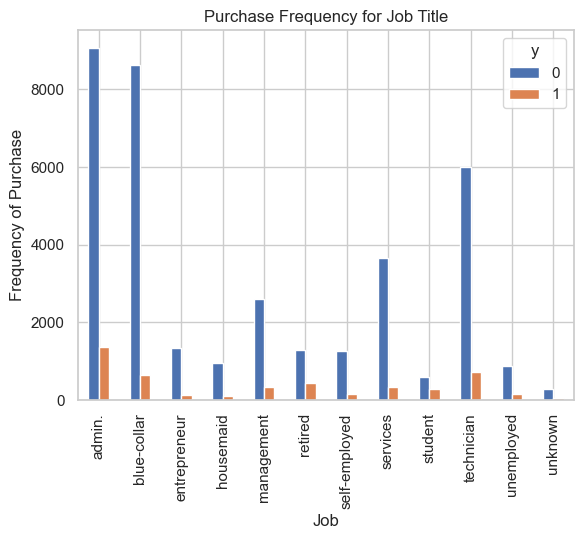

In [12]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_job')

La frecuencia de compra del depósito depende en gran medida del cargo. Así pues, el título de trabajo puede ser un buen predictor de la variable de resultado.

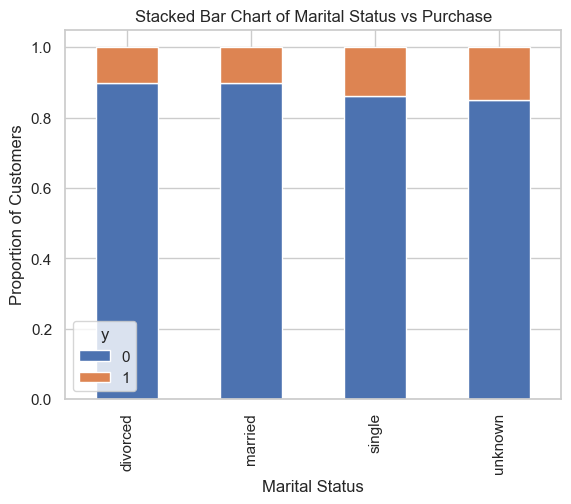

In [13]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('mariral_vs_pur_stack')

El estado civil no parece ser un fuerte predictor de la variable de resultado.

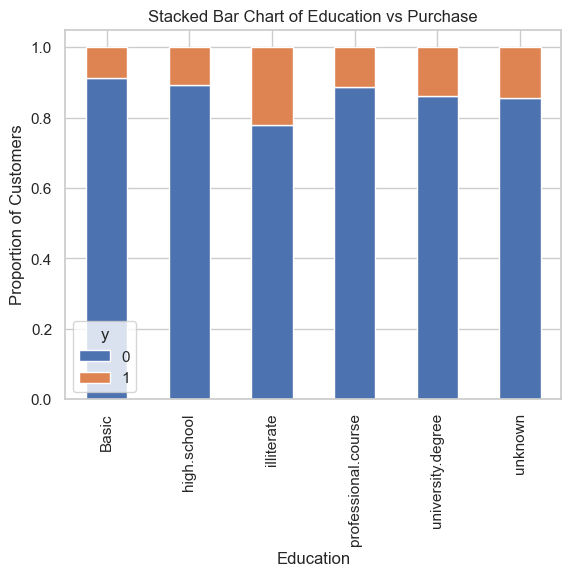

In [14]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.savefig('edu_vs_pur_stack')

La educación parece ser un buen predictor de la variable de resultado.

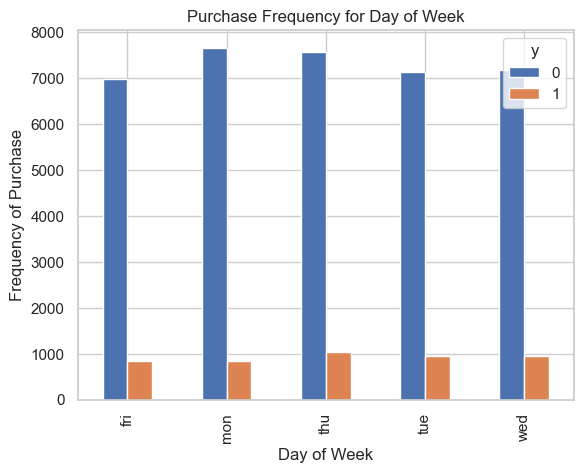

In [15]:
pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_dayofweek_bar')

El día de la semana puede no ser un buen indicador del resultado.

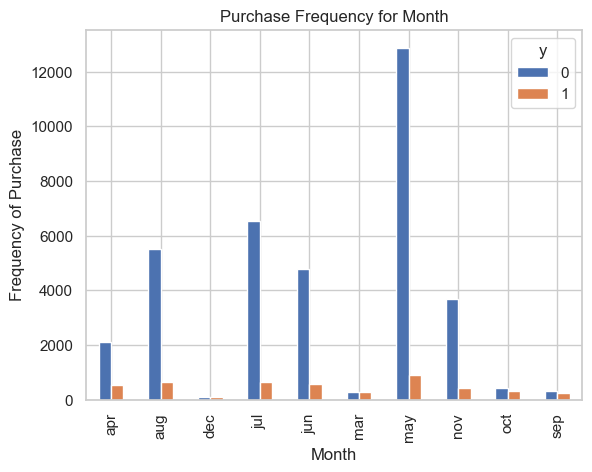

In [16]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_month_bar')

El mes podría ser un buen predictor de la variable de resultado.

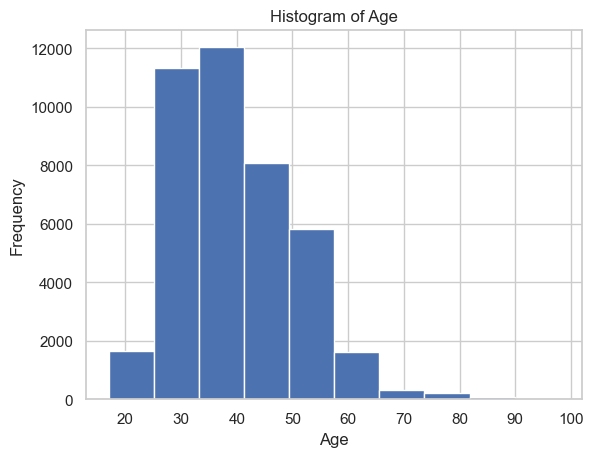

In [17]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

La mayoría de los clientes del banco en este conjunto de datos están en el rango de edad de 30-40 años.

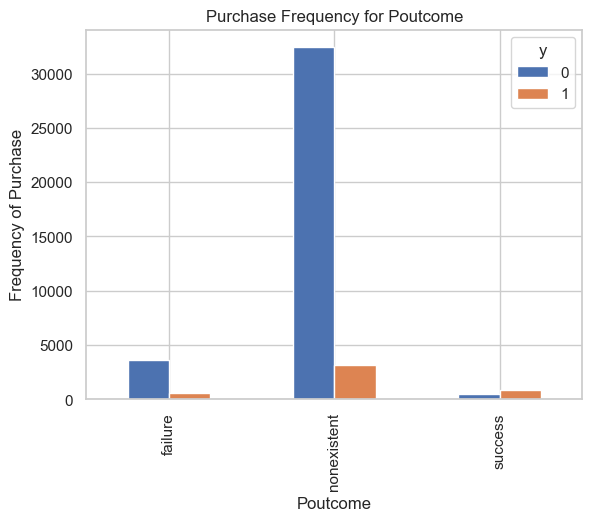

In [18]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_pout_bar')

El Poutcome parece ser un buen predictor de la variable de resultado.

### Model fitting

#### Crear variables dummy

- Transformar las siguientes variables en dummies


In [19]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

a = pd.get_dummies(data=data,columns=cat_vars,dtype='int')

df = data.copy()

- Guardar las demás variables en un dataframe

In [20]:
df = pd.concat([df, a], axis=1)
df.drop(columns=cat_vars,inplace=True)

- Separar las variables en matriz **X** y vector **y**

In [21]:
X = df.drop(columns='y')
y = data.y

- Separar los datos en train y test

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

- Ajustar la regresión logística

In [23]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

c:\Users\anoni\AppData\Local\pypoetry\Cache\virtualenvs\bootcamp-ds-R6wI3bVx-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

- Predecir con los datos de test
- Calcular accuracy

In [24]:
from sklearn.metrics import accuracy_score

pred = lr.predict(X_test)

accuracy = accuracy_score(y_test, pred)
accuracy

0.9059237679048313

### Confusion Matrix & Error Metrics

In [25]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_test, pred)
print(cm)

[[7073  222]
 [ 553  390]]


- Graficar la matriz de confusión

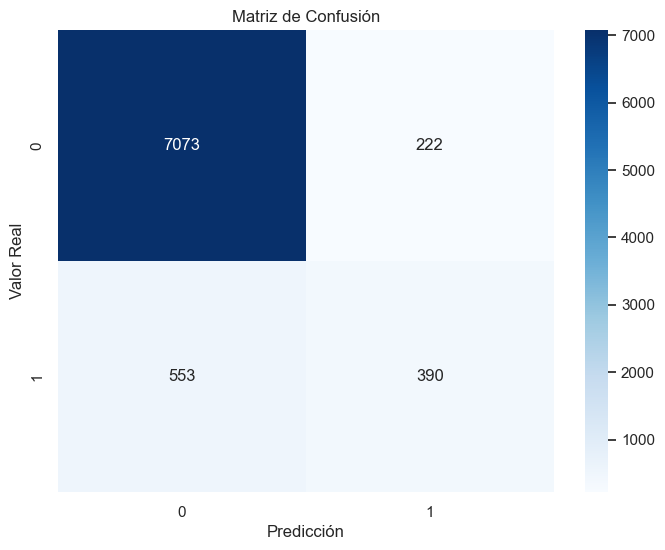

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

- Calcular precision, recall y f1 usando classification_report

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7295
           1       0.64      0.41      0.50       943

    accuracy                           0.91      8238
   macro avg       0.78      0.69      0.72      8238
weighted avg       0.89      0.91      0.90      8238



#### ROC Curve

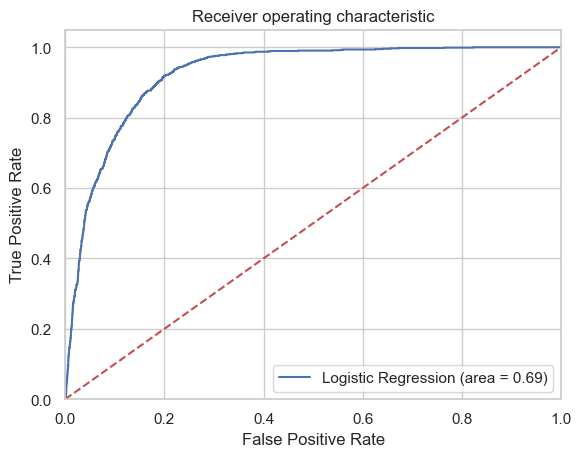

In [29]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

La curva receiver operating characteristic (ROC) es otra herramienta común utilizada con los clasificadores binarios. La línea de puntos representa la curva ROC de un clasificador puramente aleatorio; un buen clasificador se mantiene lo más alejado posible de esa línea (hacia la esquina superior izquierda).

### SMOTE Oversampling

Una vez creados nuestros datos de entrenamiento, voy a realizar un muestreo ascendente de la no-suscripción utilizando el algoritmo SMOTE (Synthetic Minority Oversampling Technique). A alto nivel, 

1.   SMOTE: Funciona creando muestras sintéticas de la clase menor (no-suscripción) en lugar de crear copias.
2.   Eligiendo aleatoriamente uno de los k-próximos y utilizándolo para crear una nueva observación similar, pero ajustada aleatoriamente.

In [44]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)

columns = X_train.columns
os_data_X,os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

# revisamos los nros en nuestra data
print("Longitud de data oversampleada: ",len(os_data_X))
print("Numero de no subscripciones en data oversampleada: ",len(os_data_y[os_data_y['y']==0]))
print("Cantidad de subscripciones: ",len(os_data_y[os_data_y['y']==1]))
print("Proporción de no subscripciones en data oversampleada: ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proporción de subscripciones en data oversampleada: ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

Longitud de data oversampleada:  51134
Numero de no subscripciones en data oversampleada:  25567
Cantidad de subscripciones:  25567
Proporción de no subscripciones en data oversampleada:  0.5
Proporción de subscripciones en data oversampleada:  0.5


Ahora tenemos unos datos perfectamente equilibrados. Puede que haya notado que he sobremuestreado sólo los datos de entrenamiento, porque al sobremuestrear sólo los datos de entrenamiento, no se utiliza ninguna información de los datos de prueba para crear observaciones sintéticas, por lo tanto, no se filtrará información de los datos de prueba al entrenamiento del modelo.

### Feature Selection

La eliminación recursiva de características (RFE - [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)) se basa en la idea de construir repetidamente un modelo y elegir la característica con mejor o peor rendimiento, apartando la característica y repitiendo el proceso con el resto de las características. Este proceso se aplica hasta que se agotan todas las características del conjunto de datos. El objetivo de la RFE es seleccionar características considerando recursivamente conjuntos de características cada vez más pequeños.

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
from sklearn.feature_selection import RFE
data_final_vars=df.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]
logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=15)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

NameError: name 'os_data_X' is not defined

In [87]:
print("RFE nos deja con las siguientes variables: ", rfe.feature_names_in_[rfe.support_])

RFE nos deja con las siguientes variables:  ['job_blue-collar' 'job_entrepreneur' 'job_housemaid' 'job_self-employed'
 'job_services' 'job_unemployed' 'job_unknown' 'education_high.school'
 'education_professional.course' 'education_university.degree'
 'education_unknown' 'day_of_week_mon' 'day_of_week_thu' 'day_of_week_tue'
 'poutcome_success']


In [35]:
cols=rfe.feature_names_in_[rfe.support_]
X_train_2=os_data_X[cols]
X_test_2=X_test[cols]
y_train_2=os_data_y['y']

AttributeError: 'RFE' object has no attribute 'feature_names_in_'

#### Train the new model:

In [37]:
logreg = LogisticRegression()
logreg.fit(X_train_2, y_train_2)
pred2 = logreg.predict(X_test_2)

NameError: name 'X_train_2' is not defined

[[8534 2447]
 [ 841  535]]


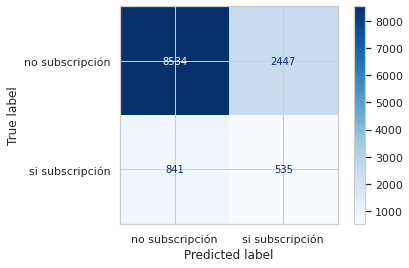

In [90]:
class_names = ['no subscripción', 'si subscripción']

disp = plot_confusion_matrix(logreg, X_test_2, y_test,
                              display_labels=class_names,
                              cmap=plt.cm.Blues)

print(disp.confusion_matrix)

In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     10981
           1       0.67      0.41      0.51      1376

    accuracy                           0.91     12357
   macro avg       0.80      0.69      0.73     12357
weighted avg       0.90      0.91      0.90     12357



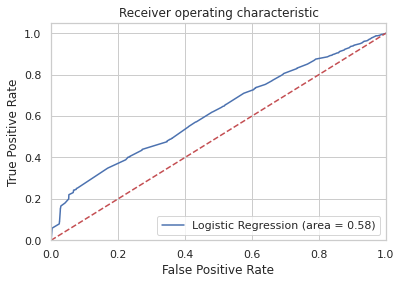

In [92]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_2))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()